In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torchvision.models
import hiddenlayer as hl
import torch
import networkx as nx
import torchviz as tv


class Net_Lin_Emotion_All(nn.Module):

    def __init__(self):
        # initiate layers
        super(Net_Lin_Emotion_All, self).__init__()
        self.lin1 = nn.Linear(8, 8)
        self.lin2 = nn.Linear(8, 4)

    def forward(self, x):
        # define forward pass
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def num_flat_features(self, x):
        self.size = x.size()[1:]
        self.num = 1
        # calculate the number of features
        for i in self.size:
            self.num *= i
        return self.num
    
network = Net_Lin_Emotion_All()
network.load_state_dict(torch.load("net_lin_emotion_all.pt"))

<All keys matched successfully>

In [2]:
for param_tensor in network.state_dict():
    print(param_tensor, "\t", network.state_dict()[param_tensor].size())
    print(network.state_dict()[param_tensor])

lin1.weight 	 torch.Size([8, 8])
tensor([[-0.2366, -0.2602, -0.1935,  0.0233, -0.2785,  0.0325,  0.1119,  0.0947],
        [-0.3504,  0.1439,  0.3480,  0.2823,  0.1955,  0.2544,  0.3029, -0.2319],
        [-0.0478, -0.0858, -0.2272, -0.3005,  0.0809, -0.2422,  0.0689,  0.1820],
        [-0.0107,  0.1091,  0.1555,  0.3177,  0.0475, -0.3188,  0.2865,  0.1334],
        [-0.4715, -0.3296, -0.2031, -0.0613, -0.1953, -0.0829,  0.2167,  0.0026],
        [-0.2384,  0.1691,  0.0393,  0.0808, -0.3162, -0.1417, -0.0380, -0.3096],
        [-0.1334, -0.2993,  0.3023,  0.2134,  0.0838,  0.0562,  0.2999, -0.3228],
        [-0.1464, -0.0498, -0.1214,  0.1162,  0.3038,  0.1650, -0.1496, -0.1350]])
lin1.bias 	 torch.Size([8])
tensor([ 0.0391, -0.1676,  0.3060, -0.2257, -0.0392,  0.1229, -0.2797,  0.0684])
lin2.weight 	 torch.Size([4, 8])
tensor([[-0.2412,  0.0414, -0.0344, -0.1603,  0.4063, -0.2482, -0.0268, -0.0408],
        [ 0.1156, -0.0575,  0.0274, -0.2093,  0.0108, -0.1830,  0.0950,  0.5237],
    

tensor([0.3161, 0.3448, 0.1488, 0.0084], grad_fn=<AddBackward0>)
True


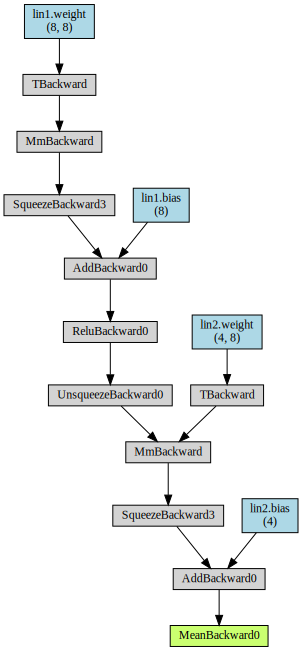

In [25]:
y = network(torch.Tensor([0,0,0,0,0,0,0,0]))
print(y)
print(torch.is_tensor(y))
tv.make_dot(y.mean(), params=dict(network.named_parameters()))

In [25]:
from torchsummary import summary

summary(model=network, input_size=(1, 8, 8), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [1, 1, 8, 8]              72
            Linear-2               [1, 1, 8, 4]              36
Total params: 108
Trainable params: 108
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [26]:
from pycore.tikzeng import *

ModuleNotFoundError: No module named 'pycore'

In [4]:
import numpy as np
pos_encoding = {84.0: 1, 85.0: 2, 86.0: 3, 87.0: 4, 89.0: 5, 90.0: 6, 91.0: 7, 92.0: 8, 93.0: 9, 
				94.0: 10, 95.0: 11, 96.0: 12, 97.0: 13, 99.0: 14, 100.0: 15, 101.0: 16, 03.0: 17, np.nan: 18}


class Lstm(nn.Module):
	def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, is_cuda, drop_prob=0.5):
		super(Lstm, self).__init__()
		# Variables
		self.device = torch.device("cuda" if is_cuda else "cpu")		
		self.is_cuda = is_cuda
		self.output_size = output_size
		self.n_layers = n_layers
		self.hidden_dim = hidden_dim
		self.batch_size = 50
		# initiate layers
		self.embedding = nn.Embedding(vocab_size,embedding_dim)
		self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
		self.lin1 = nn.Linear(hidden_dim, hidden_dim) 		
		self.lin2 = nn.Linear(hidden_dim, output_size)

	# return the initial hidden state of the lstm layer (hidden state and cell state) 	
	def init_hidden(self, batch_size):
		if self.is_cuda:
			print("Returning cuda hidden state") 
			return (torch.randn(self.n_layers, batch_size, self.hidden_dim).cuda(), torch.randn(self.n_layers, batch_size, self.hidden_dim).cuda())
		else:
			return (torch.randn(self.n_layers, batch_size, self.hidden_dim), torch.randn(self.n_layers, batch_size, self.hidden_dim))

	# propagate features through netword
	def forward(self, x, hidden):	
		x = x.long()
		
		if self.is_cuda: 
			x = x.to(self.device)
		 
		embeds = self.embedding(x) 		
		out, hidden = self.lstm(embeds, hidden)
		# take only the last hidden_dim output of the lstm 
		out = self.lin1(out[:,-1,:]) 
		out = self.lin2(out)
		return out, hidden

In [17]:
num_layers = 1
vocab_size = 18 + 1
embedding_dim = 179 
hidden_dim = 256
output_dim = 4
batch_size = 50
lr=0.001
clip = 5
is_cuda = torch.cuda.is_available()
epochs = 10
print_every = 100
# init net
lstm = Lstm(vocab_size, output_dim, embedding_dim, hidden_dim, num_layers, is_cuda, drop_prob=0.5)
hidden = (torch.randn(num_layers, 1, hidden_dim), torch.randn(num_layers, 1, hidden_dim))

In [11]:
print(lstm)

Lstm(
  (embedding): Embedding(19, 179)
  (lstm): LSTM(179, 256, batch_first=True)
  (lin1): Linear(in_features=256, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=4, bias=True)
)


In [24]:
inp =torch.Tensor([[0,0,0,0,0,0,0,0]])
y = lstm(inp, hidden)
#print(y)
print(y[0])
for i in y: 
    print("\n", i)
tv.make_dot(y[0].mean(), params=dict(network.named_parameters()))

tensor([[ 0.0154, -0.0827, -0.0512,  0.0353]], grad_fn=<AddmmBackward>)

 tensor([[ 0.0154, -0.0827, -0.0512,  0.0353]], grad_fn=<AddmmBackward>)

 (tensor([[[-0.5196,  0.3151,  0.1959, -0.0018,  0.4450,  0.3459,  0.1195,
          -0.2197, -0.1987,  0.0014, -0.1441, -0.3813,  0.0553, -0.0667,
          -0.2885,  0.2283, -0.0465,  0.1147, -0.2782,  0.0386,  0.2532,
          -0.1995, -0.3117, -0.2175, -0.1668,  0.3351, -0.2949, -0.1170,
          -0.1244, -0.0785, -0.0290,  0.3012, -0.0984, -0.3734, -0.0810,
          -0.0793,  0.1880, -0.1882,  0.0243, -0.2119, -0.2614, -0.1732,
           0.0615, -0.3130, -0.1982, -0.1438,  0.3410, -0.1490,  0.2615,
          -0.0426,  0.0321, -0.2382, -0.3412, -0.2055,  0.1933, -0.1547,
           0.2221,  0.0769, -0.2894, -0.2764,  0.2393, -0.4203, -0.1518,
           0.0385,  0.0075,  0.2788,  0.3508, -0.0424, -0.4503,  0.0722,
           0.5736,  0.0693, -0.1950,  0.0511, -0.2915,  0.1325, -0.4822,
          -0.1322,  0.0007,  0.0938, -0.3209,  0

KeyError: 140188515747592